In [9]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
# Для визуализации
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import glob

In [10]:
# Создание окружения
env = gym.make('LunarLander-v3', render_mode='rgb_array')
obs, info = env.reset(seed=0)
# Признаки.
""" |  № | Признак                  | Описание                                          |
    | -: | ------------------------ | ------------------------------------------------- |
    |  1 | `x`                      | Горизонтальное положение (относительно центра)    |
    |  2 | `y`                      | Вертикальное положение (относительно поверхности) |
    |  3 | `vx`                     | Горизонтальная скорость                           |
    |  4 | `vy`                     | Вертикальная скорость                             |
    |  5 | `θ` (angle)              | Угол наклона корабля (в радианах)                 |
    |  6 | `ω` (angular velocity)   | Угловая скорость                                  |
    |  7 | `left_contact`  ∈ {0, 1} | Есть ли контакт с левой ногой                     |
    |  8 | `right_contact` ∈ {0, 1} | Есть ли контакт с правой ногой                    |
"""
print('State shape: ', env.observation_space.shape)
# Действия.
"""
    1. Ничего не делать
    2. Стрелять левым двигателем
    3. Стрелять основным двигателем (вниз)
    4. Стрелять правым двигателем
"""
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [11]:
# Q-сеть - нейронная сеть, которая используется как аппроксиматор Q-функции в алгоритме DQN (Deep Q-Learning).
class QNetwork(nn.Module):
    """Агент (Политика) модели."""
    def __init__(self, state_size, action_size, seed):
        """ Инициализируем параметры и строим модель.
            Параметры
            =========
            state_size (int): число состояний (их 8)
            action_size (int): число действий (их 4)
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)  # 8 -> 64
        self.fc2 = nn.Linear(64, 64)          # 64 -> 64  - на 8 входов приходится 1 правильное действие (перцептрон-классификатор) 
        self.fc3 = nn.Linear(64, action_size) # 64 -> 4

    def forward(self, state):
        """ Построение сети, которая сопоставляет 'состояние'-> 'дейтсвие' """
        x = self.fc1(state) # на вход кидаем вектор признаков
        x = F.relu(x)       # функция нелинейности
        x = self.fc2(x)     # результат кидаем на второй слой
        x = F.relu(x)       # функция нелинейности
        return self.fc3(x)  # результат кидаем на третий слой

In [12]:
# Гиперпараметры.
BUFFER_SIZE = int(1e5) # размер реплей-буффера - хранит изученные опыты
BATCH_SIZE = 64        # размер батча (мини-батча) - число опытов из буфера
GAMMA = 0.99           # коэффициент дисконтирования
TAU = 1e-3             # коэффициент обновления (мягкого) весов целевой сети
LR = 5e-4              # скорость обучения
UPDATE_EVERY = 4       # частота обновления сети

In [13]:
# Буфер - буфер опыта агента. Он хранит всё, что происходило в среде: состояния, действия, награды и т.д., чтобы позже использовать это для обучения.
class ReplayBuffer:
    """Буфер фиксированного размера для хранения кортежей опыта."""
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """ Инициализация буфера.
            Параметры
            =========
            action_size (int): число действий (их 4)
            buffer_size (int): максимальный размер буфера
            batch_size (int): размер батча
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        self.action_size = action_size
        # Используется очередь с ограничением по размеру. Если добавлять больше, чем buffer_size, самые старые элементы удаляются автоматически/
        self.memory = deque(maxlen=buffer_size) 
        self.batch_size = batch_size
        # Создаtтся удобный тип данных Experience, чтобы хранить одно событие (один переход в среде). Это как структурированный контейнер.
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):
        """Добавление нового опыта в память."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        """Произвольно выбирает из памяти подмножество событий без повторения."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        """Возвращает текущий размер внутренней памяти."""
        return len(self.memory)

In [14]:
# Агент - ядро DQN-алгоритма, отвечающее за принятие решений, обучение и управление буфером опыта.
class Agent:
    """Взаимодействует с окружающей средой и учится у нее."""
    def __init__(self, state_size, action_size, seed):
        """ Инициализация агента.
            Параметры
            =========
            state_size (int): число состояний (их 8)
            action_size (int): число действий (их 4)
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-сеть.
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)  # выбирает действия, на них учится - основная сеть
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device) # используется при обучение с плавным обновлением весов
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)      # оптимизатор

        # Буфер опыта - как блокнот, где записываются все шаги: s, a, r, s', done.
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Инициализация временного шага (для обновления каждого шага UPDATE_EVERY).
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        """ Шаг в среде и потенциальное обучение. """
        # Сохранение опыта в буфер опыта.
        self.memory.add(state, action, reward, next_state, done)
        # Обновление параметра временного шага на основе UPDATE_EVERY.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        # Если в памяти достаточно образцов, получить случайное подмножество и изучить его.
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """ Возвращает действия для заданного состояния в соответствии с текущей политикой.
            Параметры
            =========
            state (array_like): текущее состояние
            eps (float): эпсилон, для выбора действия согласно эпсилон-жадности
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        # Выбор действия согласно эпсилон-жаности.
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ Обновить параметры значений, используя заданный набор кортежей опыта.
            Params
            ======
            experiences (Tuple[torch.Variable]): тензор из (s, a, r, s', done) кортежей
            gamma (float): коэффициент дисконтирования
        """
        # Получить случайный мини-пакет кортежей из D.
        states, actions, rewards, next_states, dones = experiences
        ## Вычислить и минимизировать потери.
        ### Извлечь следующее максимальное оценочное значение из целевой сети.
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Вычислить целевое значение из уравнения Беллмана.
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Вычислить ожидаемое значение основной сети.
        q_expected = self.qnetwork_local(states).gather(1, actions)
        ### Вычислить потери (мы использовали среднеквадратичную ошибку).
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # ------------------- обновление целевой сети ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """ Мягкое обновление параметров сети.
            θ_target = τ*θ_local + (1 - τ)*θ_target
            Параметры
            =========
            local_model (PyTorch model): веса будут скопированы отсюда
            target_model (PyTorch model): веса будут скопированы сюда
            tau (float): интерполяция параметров
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [15]:
# DQN обучение.
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """ Deep Q-Learning.
        Params
        ======
        n_episodes (int): максимальное число эпизодов.
        max_t (int): максимальное число шагов в эпизоде.
        eps_start (float): начальное значение epsilon для выбора действия согласно epsilon-жадности.
        eps_end (float): минимальное значение epsilon.
        eps_decay (float): мультипликативный фактор (за эпизод) для уменьшения epsilon.
    """
    scores = [] # список, содержащий оценки из каждого эпизода
    scores_window = deque(maxlen=100)  # последние 100 результатов
    eps = eps_start # инициализация epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score) # # сохранить последний результат
        scores.append(score) # # сохранить последний результат
        eps = max(eps_end, eps_decay * eps) # уменьшение epsilon
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}")
        if np.mean(scores_window) >= 200.0:
            print(f"\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}")
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [16]:
# Обучение
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -148.08
Episode 200	Average Score: -110.74
Episode 300	Average Score: -46.976
Episode 400	Average Score: -9.061
Episode 500	Average Score: 40.319
Episode 600	Average Score: 103.66
Episode 700	Average Score: 199.69
Episode 703	Average Score: 200.38
Environment solved in 603 episodes!	Average Score: 200.38


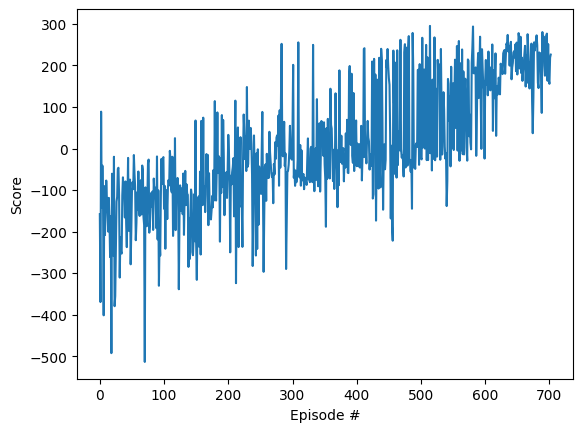

In [17]:
# График обучения
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [18]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [19]:
import time
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    env = RecordVideo(env, video_folder=f"video_{int(time.time())}", episode_trigger=lambda x: True)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    obs, _ = env.reset()
    done = False
    while not done:
        frame = env.render()
        action = agent.act(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    env.close()

agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v3')
show_video('LunarLander-v3')